In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
from pandas import read_csv
import pandas as pd
from collections import Counter

from sklearn.preprocessing import StandardScaler
%matplotlib inline

train = pd.read_csv('dataset/sales_train.csv')
test = pd.read_csv('dataset/test.csv')
shops = pd.read_csv('dataset/shops.csv')
items = pd.read_csv('dataset/items.csv')
items_categories = pd.read_csv('dataset/item_categories.csv')
submission = pd.read_csv('dataset/sample_submission.csv')
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [3]:
from datetime import datetime

#find missing date
def datekey(item):
    date, _ = item
    #print(date)
    d, m, y = date.split('.')
    #print(y+m+d)
    return y+m+d

def getdatelist(beginDate, endDate):
    date_l=[datetime.strftime(x,'%d.%m.%Y') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

datelist = Counter(train['date'])
datelist = sorted(datelist.items(), key=datekey)
print(len(datelist))
#01.01.2013 - 31.10.2015

fulldatelist = getdatelist('20130101', '20151031')
print(len(fulldatelist))

1034
1034


Counter({1.0: 2163, 2.0: 136, 3.0: 20, -1.0: 3, 4.0: 2, 17.0: 1})
item_id: 2574


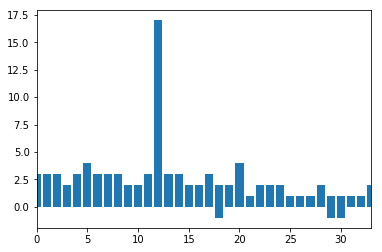

In [4]:

#sale month
def bar_sale_item(data, itemid):
    selected_data = data[data.item_id==itemid]
    selected_item_cnt_day = selected_data['item_cnt_day']
    print(Counter(selected_item_cnt_day))
    print("item_id:",itemid)
    plt.xlim((0,33))
    plt.bar(selected_data['date_block_num'], selected_data['item_cnt_day'])
    return

#Counter(train['date_block_num']) #34months
bar_sale_item(train, 2574)

1562733.0
1320889.0
764584.0


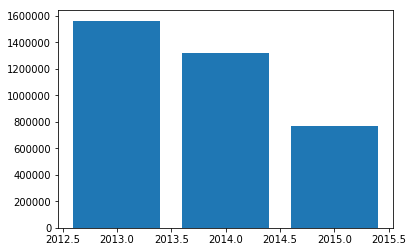

In [5]:

def bar_sale_year(data):
    data['year'] = data['date'].str.split('.').str[2]
    total_sale = []
    for i in range(2013, 2016):
        selected_data = data[data.year==str(i)]
        print(sum(selected_data['item_cnt_day']))
        total_sale.append(sum(selected_data['item_cnt_day']))
    plt.bar(range(2013,2016), total_sale)
    return

bar_sale_year(train)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


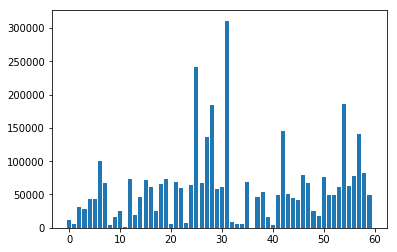

In [6]:
def bar_sale_shopid(data):
    shopidlist = sorted(Counter(data['shop_id']))
    print(shopidlist)
    sale_of_shopid_list = []
    for i in shopidlist:
        selecteddata = data[data.shop_id==i]
        sale_of_shopid_list.append(sum(selecteddata['item_cnt_day']))
    plt.bar(shopidlist, sale_of_shopid_list)
    return

bar_sale_shopid(train)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


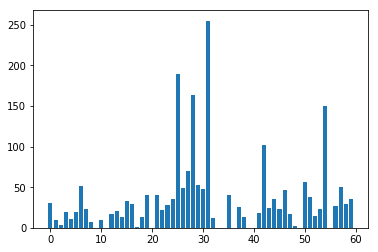

In [7]:
#sale shopid
def saleitem_shopid(data, itemid):
    shopidlist = sorted(Counter(data['shop_id']))
    print(shopidlist)
    sale_of_shopid_list = []
    '''
    for i in shopidlist:
        print('shop',i)
        selecteddata = data[data.shop_id==i]
        g = selecteddata.groupby('item_id')
        print(g['item_cnt_day'].sum())
    '''
    sale_of_item = []
    for i in shopidlist:
        selecteddata = data[(data.shop_id==i) & (data.item_id==itemid)]
        sale_of_item.append(sum(selecteddata['item_cnt_day']))
    plt.bar(shopidlist, sale_of_item)
    return

saleitem_shopid(train, 30)


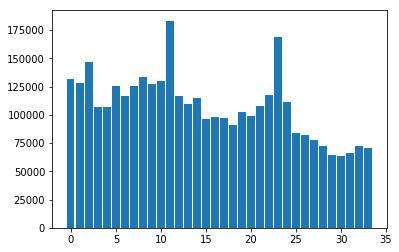

In [8]:
#month(x) item cnt day(y)
def bar_month_itemcntday(data):
    g = data.groupby('date_block_num')
    date_item = g['item_cnt_day'].sum()
    plt.bar(range(34), date_item)
    return

#Counter(train['date_block_num']) #34months
bar_month_itemcntday(train)

In [9]:
dataset = train.pivot_table(
    index=['item_id', 'shop_id'],values=['item_cnt_day'], columns='date_block_num', fill_value=0)
dataset.head()

item_cnt_day                                               \
date_block_num            0    1    2    3    4    5    6    7    8    9    
item_id shop_id                                                             
0       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       55               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       54               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                ...                                                     
date_block_num  ...    24   25   26   27   28   29   30   31   32   33  
item_id shop_id ...                                                     
0       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       55      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       54      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [10]:
dataset = dataset.reset_index()
dataset.head()

item_id shop_id item_cnt_day                                \
date_block_num                            0    1    2    3    4    5    6   
0                    0      54          0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1                    1      55          0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2                    2      54          0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3                    3      54          0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4                    4      54          0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                    ...                                                     
date_block_num    7 ...    24   25   26   27   28   29   30   31   32   33  
0               0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1               0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2               0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3               0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4               0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 36 columns]

In [11]:
dataset = pd.merge(test, dataset, on=['item_id', 'shop_id'], how='left')
dataset = dataset.fillna(0)
dataset.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
dataset = dataset.drop(['shop_id', 'item_id', 'ID'], axis=1)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train = np.expand_dims(dataset.values[:, :-1], axis=2)
y_train = dataset.values[:, -1:]

X_test = np.expand_dims(dataset.values[:, 1:], axis=2)

print(X_train.shape, y_train.shape, X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(units=64, input_shape=(33, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, batch_size=4096, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
214200/214200 [==============================] - 34s 159us/step - loss: 1.3677 - mean_squared_error: 1.3677
Epoch 2/10
214200/214200 [==============================] - 32s 148us/step - loss: 1.3616 - mean_squared_error: 1.3616
Epoch 3/10
214200/214200 [==============================] - 34s 160us/step - loss: 1.3573 - mean_squared_error: 1.3573
Epoch 4/10
214200/214200 [==============================] - 34s 158us/step - loss: 1.3476 - mean_squared_error: 1.3476
Epoch 5/10
214200/214200 [==============================] - 31s 144us/step - loss: 1.3466 - mean_squared_error: 1.3466
Epoch 6/10
214200/214200 [==============================] - 32s 152us/step - loss: 1.3537 - mean_squared_error: 1.3537
Epoch 7/10
214200/214200 [==============================] - 32s 149us/step - loss: 1.3337 - mean_squared_error: 1.3337
Epoch 8/10
214200/214200 [==============================] - 36s 166us/step - loss: 1.3456 - mean_squared_error: 1.3456


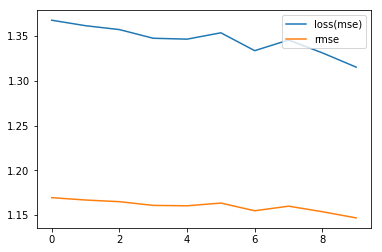

In [16]:
plt.plot(history.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(history.history['mean_squared_error']), label= 'rmse')
plt.legend(loc=1)

In [17]:
LSTM_prediction = model.predict(X_test)
LSTM_prediction

array([[0.4094618 ],
       [0.06966306],
       [0.5643975 ],
       ...,
       [0.07330249],
       [0.06966306],
       [0.06003399]], dtype=float32)

In [18]:
submission = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': LSTM_prediction.ravel()})
submission.to_csv('submission.csv',index=False)